In [5]:
!pip install torch torchmetrics torchvision 

  Using cached torchvision-0.22.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 5.7 MB/s eta 0:00:00a 0:00:01
Using cached torchvision-0.22.0-cp312-cp312-macosx_11_0_arm64.whl (1.9 MB)


In [6]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy
import torch
import torch.nn.init as init
import shutil
import zipfile
import os
import gdown
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [8]:
# Setting device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
  device = "mps"
elif torch.device("cpu"):
  device = "cpu"

print("The type of devise: ",device)
print("The version of torch:", torch.__version__)

The type of devise:  mps
The version of torch: 2.7.0


In [9]:
def extract_gdrive_file(folder_id, output_path):
    '''
    Download and extract a ZIP file from Google Drive.
    Parameters:
    - folder_id (str): The unique ID of the file from G Drive link.
    - output_path (str): The path where the files will be extracted.
    '''
    # check whether the data already exists
    if os.path.exists(output_path) and len(os.listdir(output_path)) > 0:
        print("Data already exists. I'm skipping the downloading and unpacking.")
        return

    # create file for extracted files, if not existed
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # download file from Google Drive
    zip_url = f"https://drive.google.com/uc?export=download&id={folder_id}"
    zip_filename = os.path.join(output_path, "brain_tumors_img.zip")
    print(f"Downloading file from Google Drive to {zip_filename}...")
    gdown.download(zip_url, zip_filename, quiet=False)

    # extract the file to output path
    print(f"Unzipping file: {zip_filename}...")
    try:
        with zipfile.ZipFile(zip_filename, "r") as zip_ref:
            zip_ref.extractall(output_path)
        print("Unzipping of the file is complete!")
    except zipfile.BadZipFile:
        print("Error: The downloaded file is not a valid ZIP archive.")
        return

    # delete zip file after extraction
    os.remove(zip_filename)
    print("ZIP file has been removed!")

    # Remove the _MACOSX folder if exists
    macosx_path = os.path.join(output_path, '__MACOSX')
    if os.path.exists(macosx_path):
        shutil.rmtree(macosx_path)
        print("_MACOSX folder has been removed!")

    # Remove .DS_Store files from the extracted folders
    for root, dirs, files in os.walk(output_path):
        for file in files:
            if file == ".DS_Store":
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Removed file: {file_path}")



FOLDER_ID = "1xHeIOOHUFlnTxuSJzwuoVMmb3iz-oHlB"
OUTPUT_PATH = "./data/tumors"
extract_gdrive_file(FOLDER_ID, OUTPUT_PATH)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1xHeIOOHUFlnTxuSJzwuoVMmb3iz-oHlB
From (redirected): https://drive.google.com/uc?export=download&id=1xHeIOOHUFlnTxuSJzwuoVMmb3iz-oHlB&confirm=t&uuid=9f902eef-ed5a-4514-9127-bcab7b555b37
To: /Users/franekbiskup/Desktop/Portfolio/brain_tumors/data/tumors/brain_tumors_img.zip
100%|██████████| 159M/159M [00:20<00:00, 7.74MB/s] 


Unzipping file: ./data/tumors/brain_tumors_img.zip...
Unzipping of the file is complete!
ZIP file has been removed!
_MACOSX folder has been removed!
Removed file: ./data/tumors/brain_tumors_img/.DS_Store
Removed file: ./data/tumors/brain_tumors_img/Training/.DS_Store
Removed file: ./data/tumors/brain_tumors_img/Testing/.DS_Store


In [11]:
# directories for images
train_dir = ('data/tumors/brain_tumors_img/Training')
test_dir = ('data/tumors/brain_tumors_img/Testing')
train_dir, test_dir

('data/tumors/brain_tumors_img/Training',
 'data/tumors/brain_tumors_img/Testing')

In [16]:
categories = os.listdir(train_dir)
print(categories)

['pituitary', 'notumor', 'glioma', 'meningioma']


In [17]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    #transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    #transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [18]:
train_dataset = torchvision.datasets.ImageFolder(root = train_dir, transform = train_transforms)
test_dataset  = torchvision.datasets.ImageFolder(root = test_dir, transform = test_transforms)

In [19]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True) # try others batch_size eg. 64, 128, 256, 512
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [20]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=15, shuffle = True)
    batch = next(iter(loader))
    images, labels = batch

    plt.figure(figsize = (12,8))
    for i, img in enumerate(images):
      plt.subplot(3, 5, i+1)
      plt.imshow(np.transpose(img, (1,2,0)))
      plt.title(categories[labels[i].item()])
      plt.axis('off')

    plt.tight_layout()
    plt.show()



def plot_class_distribution(dataset, dataset_name):
    labels = [label for _, label in dataset]
    label_counts = {label: labels.count(label) for label in set(labels)}

    plt.figure(figsize=(10, 8))
    plt.bar(label_counts.keys(), label_counts.values(), color=['navy', 'teal', 'darkorange', 'crimson'])
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(f"{dataset_name} Set Distribution")
    plt.xticks(list(label_counts.keys()), categories)
    plt.show()

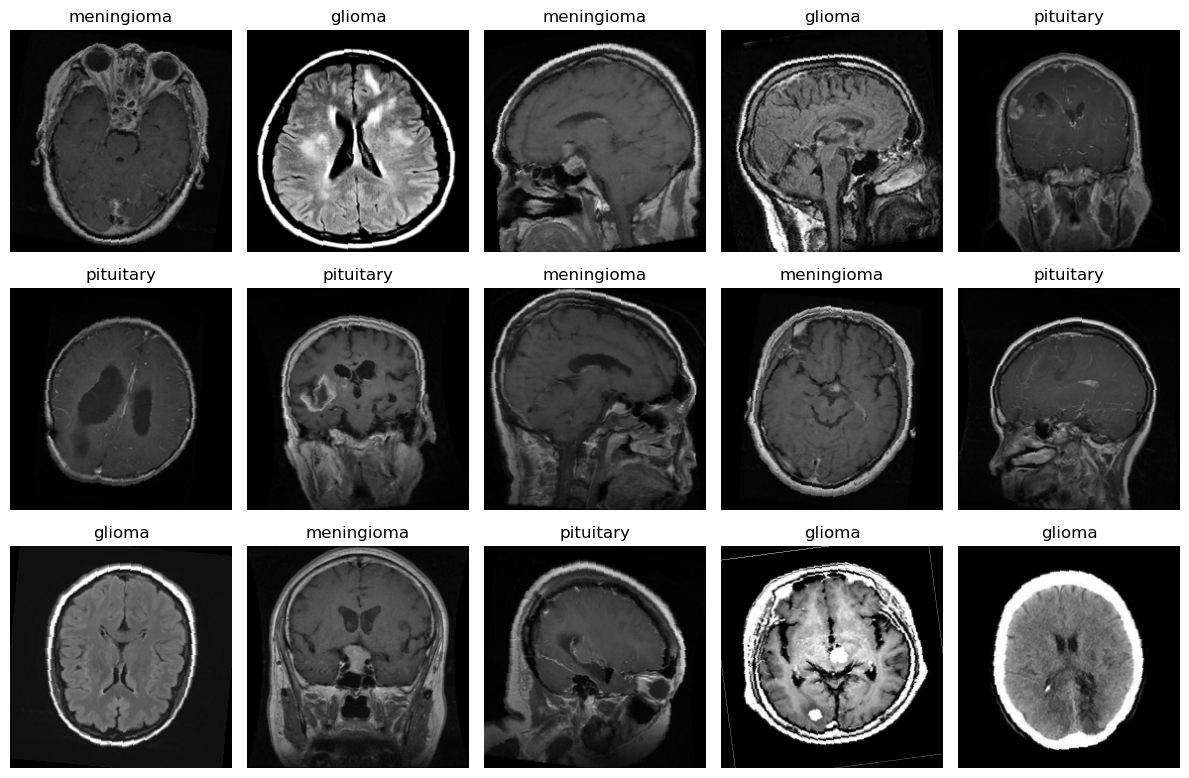

In [21]:
show_transformed_images(train_dataset)

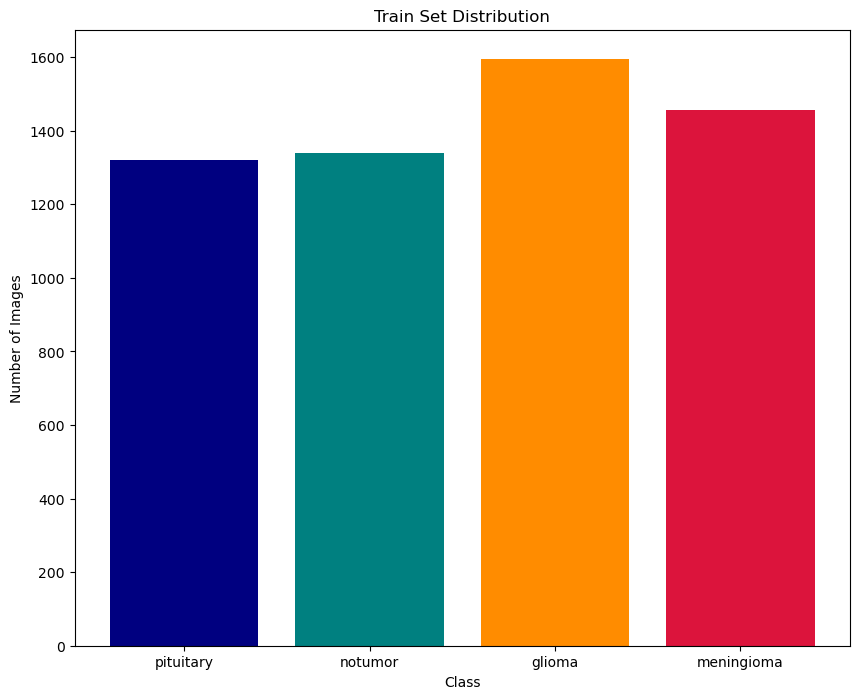

In [22]:
plot_class_distribution(train_dataset, "Train")

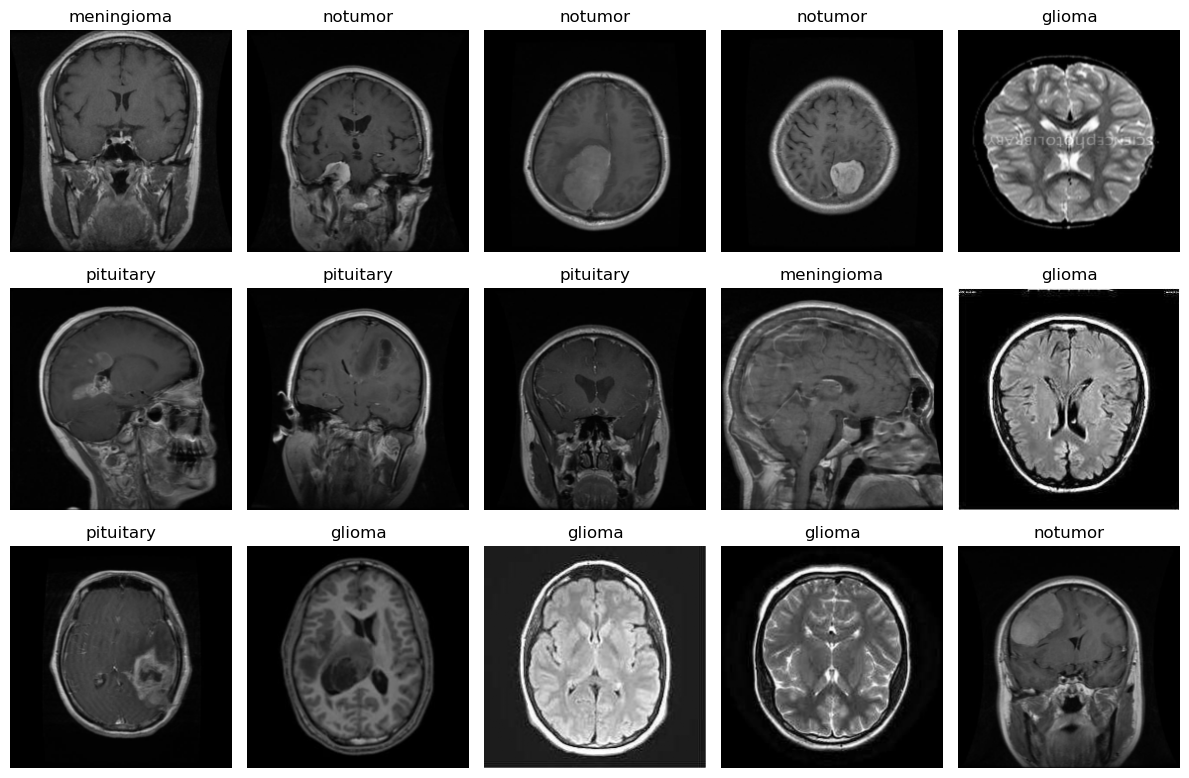

In [23]:
show_transformed_images(test_dataset)

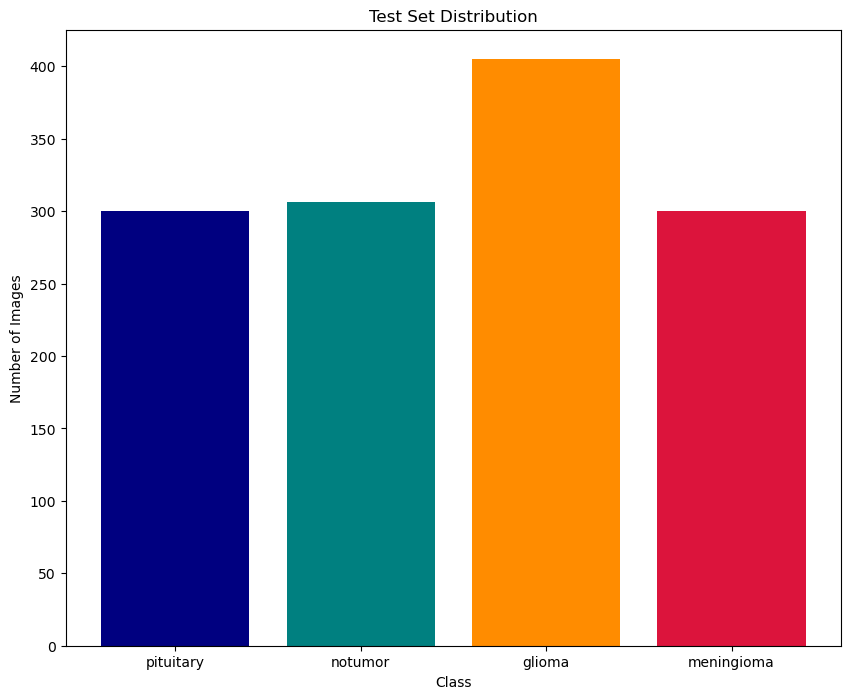

In [24]:
plot_class_distribution(test_dataset, "Test")